# Installing Dependancies


In [16]:
%pip install tensorflow numpy librosa soundfile matplotlib pandas scikit-learn pyaudio pydub


Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install numpy os json-tricks pydub librosa noisereduce tensorflow keras scikit-learn 


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\users\admin\desktop\ser\.venv\lib\site-packages (2.0.2)



ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
!pip install pydub
!pip install noisereduce
!pip install json-tricks
!pip install tensorflow
!pip install keras


# Importing Libraries

In [1]:
import numpy as np

import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr
%pip install tensorflow

import tensorflow as tf
import keras
import sklearn

c:\Users\Admin\Desktop\SER\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Note: you may need to restart the kernel to use updated packages.


# Path to directory

In [2]:
import os

# Set the path to your local dataset
dataset_path = "C:/Users/Admin/Desktop/SER/Dataset"  # Update this path

# Verify the path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path does not exist: {dataset_path}")
print(f"Dataset directory found: {dataset_path}")


Dataset directory found: C:/Users/Admin/Desktop/SER/Dataset


In [3]:
# Function to map emotion from the TESS database based on keywords in filenames
def find_emotion_T(filename):
    """Identify emotion label based on keywords in TESS dataset filenames."""
    emotion_map = {
        'neutral': "01",
        'happy': "03",
        'sad': "04",
        'angry': "05",
        'fear': "06",
        'disgust': "07",
        'ps': "08",  # ps stands for "pleasant surprise"
    }
    
    # Iterate through the mapping and find the corresponding emotion
    for key, value in emotion_map.items():
        if key in filename.lower():  # Case-insensitive match
            return value
    
    # Return -1 for unrecognized emotions
    return "-1"

# Function to convert emotion numerical labels into zero-based classification indices
def emotionfix(e_num):
    """
    Adjust numerical emotion labels to zero-based indices for classification.
    :param e_num: A string representing the emotion code.
    :return: An integer representing the zero-based emotion index.
    """
    emotion_classification = {
        "01": 0,  # neutral
        "02": 1,  # calm (if applicable to your dataset)
        "03": 2,  # happy
        "04": 3,  # sad
        "05": 4,  # angry
        "06": 5,  # fear
        "07": 6,  # disgust
        "08": 7,  # surprised
    }

    # Return the corresponding index or -1 for unrecognized codes
    return emotion_classification.get(e_num, -1)  # Default to -1 for unknown labels


# Preprocess 

In [4]:
import os
import librosa
import numpy as np

# Specify the local folder containing the audio files
folder_path = "C:/Users/Admin/Desktop/SER/Dataset"  # Update this to your local folder path

# List to store sample lengths
sample_lengths = []

# Walk through the folder and process each file
for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        # Construct the full file path
        file_path = os.path.join(subdir, file)
        
        try:
            # Load the audio file
            x, sr = librosa.load(path=file_path, sr=None)
            
            # Trim silence from the audio
            xt, index = librosa.effects.trim(x, top_db=30)
            
            # Append the length of the trimmed audio to the list
            sample_lengths.append(len(xt))
        except Exception as e:
            # Print error message if a file cannot be processed
            print(f"Error processing file {file_path}: {e}")

# Calculate and print the maximum sample length
if sample_lengths:
    print("Maximum sample length:", np.max(sample_lengths))
else:
    print("No valid audio files were processed.")


Maximum sample length: 204288


In [5]:
import time
import os
import numpy as np
from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

# Import emotion validation functions
def find_emotion_T(filename):
    emotion_map = {
        'neutral': "01",
        'happy': "03",
        'sad': "04",
        'angry': "05",
        'fear': "06",
        'disgust': "07",
        'ps': "08",  # ps stands for "pleasant surprise"
    }
    for key, value in emotion_map.items():
        if key in filename.lower():
            return value
    return "-1"

def emotionfix(e_num):
    emotion_classification = {
        "01": 0,  # neutral
        "02": 1,  # calm
        "03": 2,  # happy
        "04": 3,  # sad
        "05": 4,  # angry
        "06": 5,  # fear
        "07": 6,  # disgust
        "08": 7,  # surprised
    }
    return emotion_classification.get(e_num, -1)

# Start timer
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 173056  # Desired frame length for all audio samples
frame_length = 2048
hop_length = 512

# Update folder_path to local dataset
folder_path = "C:/Users/Admin/Desktop/SER/Dataset"  # Replace with your local path

# Walk through the folder structure and process each file
for subdir, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            # Fetch the sample rate
            _, sr = librosa.load(path=file_path, sr=None)  # Ignore returned audio as it's not used
            
            # Load the audio file
            rawsound = AudioSegment.from_file(file_path)
            
            # Normalize the audio
            normalizedsound = effects.normalize(rawsound, headroom=0)
            
            # Convert to numpy array
            normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')
            
            # Trim silence
            xt, index = librosa.effects.trim(normal_x, top_db=30)
            
            # Pad for duration equalization
            if len(xt) < total_length:
                padded_x = np.pad(xt, (0, total_length - len(xt)), 'constant')
            else:
                padded_x = xt[:total_length]
            
            # Noise reduction
            final_x = nr.reduce_noise(y=padded_x, sr=sr)
            
            # Feature extraction
            f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length)
            f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length, center=True)
            f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length=hop_length)
            
            # Extract emotion label
            if find_emotion_T(file) != "-1":  # TESS database
                emotion_code = find_emotion_T(file)
            else:  # RAVDESS database
                emotion_code = file[6:8]
            
            # Append features and emotion label
            rms.append(f1)
            zcr.append(f2)
            mfcc.append(f3)
            emotions.append(emotionfix(emotion_code))
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# End timer
toc = time.perf_counter()
print(f"Running time: {(toc - tic) / 60:0.4f} minutes")


Running time: 17.0588 minutes


In [6]:

import numpy as np

# Assuming rms, zcr, and mfcc are already populated with feature extraction
f_rms = np.asarray(rms).astype('float32')
f_zcr = np.asarray(zcr).astype('float32')
f_mfccs = np.asarray(mfcc).astype('float32')

# Ensure they have the correct dimensions
print('Original RMS shape:', f_rms.shape)
print('Original ZCR shape:', f_zcr.shape)
print('Original MFCC shape:', f_mfccs.shape)

# We need to adjust the dimensions from (samples, frames, features) to (samples, timesteps, features)
# We check and fix dimension mismatch by swapping axes accordingly

# Ensure correct axis for RMS (e.g., (n_samples, n_frames, n_features) to (n_samples, n_timesteps, n_features))
f_rms = np.swapaxes(f_rms, 1, 2)  # swap axis 1 (frames) with axis 2 (features)
f_zcr = np.swapaxes(f_zcr, 1, 2)  # similarly for ZCR
f_mfccs = np.swapaxes(f_mfccs, 1, 2)  # similarly for MFCCs

# Print the adjusted shapes to confirm they are correct
print('Adjusted RMS shape:', f_rms.shape)
print('Adjusted ZCR shape:', f_zcr.shape)
print('Adjusted MFCC shape:', f_mfccs.shape)

# Now, f_rms, f_zcr, and f_mfccs should all have the shape (samples, timesteps, features)


Original RMS shape: (2881, 1, 339)
Original ZCR shape: (2881, 1, 339)
Original MFCC shape: (2881, 13, 339)
Adjusted RMS shape: (2881, 339, 1)
Adjusted ZCR shape: (2881, 339, 1)
Adjusted MFCC shape: (2881, 339, 13)


In [7]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')  # Ensure Y is an array of integers
Y = np.expand_dims(Y, axis=1)  # Convert to shape (samples, 1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


Shape of X: (2881, 339, 15)
Shape of Y: (2881, 1)


In [ ]:
import json

# Convert X and Y (NumPy arrays) to lists
x_data = X.tolist()  # Converts NumPy array X to a list
y_data = Y.tolist()  # Converts NumPy array Y to a list

# Define file paths for saving as JSON
x_path = 'X_data_list.json'  # File path for X data
y_path = 'Y_data_list.json'  # File path for Y data

# Save the X data as a JSON file
with open(x_path, 'w') as x_file:
    json.dump(x_data, x_file)

# Save the Y data as a JSON file
with open(y_path, 'w') as y_file:
    json.dump(y_data, y_file)

# Confirmation message
print(f"X and Y data have been saved as lists to {x_path} and {y_path}.")


X and Y data have been saved as lists to X_data_list.json and Y_data_list.json.


In [11]:
import json
import numpy as np

# Define local file paths
x_path = 'X_data_list.json'  # Local file path for X data
y_path = 'Y_data_list.json'  # Local file path for Y data

# Load X data from the JSON file
with open(x_path, 'r') as x_file:
    X = json.load(x_file)  # Load data as a Python list

# Convert X to a numpy array with the appropriate data type
X = np.asarray(X, dtype='float32')

# Load Y data from the JSON file
with open(y_path, 'r') as y_file:
    Y = json.load(y_file)  # Load data as a Python list

# Convert Y to a numpy array with the appropriate data type
Y = np.asarray(Y, dtype='int8')

# Check the shapes of the loaded data
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")


X shape: (2881, 339, 15)
Y shape: (2881, 1)


In [13]:
# Check the shapes of X and Y
print(f"Shape of X before alignment: {X.shape}")
print(f"Shape of Y before alignment: {Y.shape}")

# Align the data (assuming the smaller dimension is correct)
num_samples = min(X.shape[0], Y.shape[0])
X = X[:num_samples]
Y = Y[:num_samples]

# Verify the alignment
print(f"Shape of X after alignment: {X.shape}")
print(f"Shape of Y after alignment: {Y.shape}")

# Proceed with train_test_split
from sklearn.model_selection import train_test_split
import tensorflow as tf

x_train, x_tosplit, y_train, y_tosplit = train_test_split(
    X, Y, test_size=0.125, random_state=1
)

x_val, x_test, y_val, y_test = train_test_split(
    x_tosplit, y_tosplit, test_size=0.304, random_state=1
)

# Print shapes to verify splits
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

# One-hot encoding without dtype argument for compatibility with older TensorFlow versions
y_train_class = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_class = tf.keras.utils.to_categorical(y_val, num_classes=8)

# Print shapes
print(f"y_train_class shape: {y_train_class.shape}")
print(f"y_val_class shape: {y_val_class.shape}")



Shape of X before alignment: (2881, 339, 15)
Shape of Y before alignment: (2881, 1)
Shape of X after alignment: (2881, 339, 15)
Shape of Y after alignment: (2881, 1)
x_train shape: (2520, 339, 15)
x_val shape: (251, 339, 15)
x_test shape: (110, 339, 15)
y_train shape: (2520, 1)
y_val shape: (251, 1)
y_test shape: (110, 1)
y_train_class shape: (2520, 8)
y_val_class shape: (251, 8)


In [14]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(2520, 339, 15)
(251, 339, 15)
(110, 339, 15)


In [15]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[4], [5], [6], [6], [6], [2], [3], [3], [3], [6], [1], [7], [6], [7], [4], [4], [1], [5], [3], [1], [6], [6], [1], [4], [2], [5], [1], [6], [4], [2], [2], [7], [7], [2], [0], [7], [7], [2], [6], [3], [7], [3], [4], [7], [7], [6], [7], [6], [6], [3], [3], [6], [7], [1], [1], [3], [6], [5], [6], [6], [7], [5], [3], [0], [2], [0], [2], [6], [6], [4], [4], [7], [7], [5], [4], [1], [3], [1], [1], [2], [3], [3], [4], [5], [5], [3], [6], [0], [5], [3], [0], [5], [1], [7], [2], [3], [7], [2], [6], [3], [0], [5], [4], [2], [1], [1], [3], [3], [0], [5]], "dtype": "int8", "shape": [110, 1], "Corder": true}'

In [17]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 
%pip install tensorflow.keras.models
%pip install tensorflow.keras
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow.keras.models (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.models


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


Note: you may need to restart the kernel to use updated packages.


In [19]:
# Import necessary modules
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks

# Define the LSTM model
model = Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    layers.LSTM(64),
    layers.Dense(8, activation='softmax')  # 8 classes
])
print(model.summary())

# Batch size
batch_size = 23

# Define directory and path for saving the best weights
checkpoint_dir = os.path.join(os.getcwd(), "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure directory exists
checkpoint_path = os.path.join(checkpoint_dir, "best_weights.keras")

# Define callbacks
# Save the best model weights
mcp_save = callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_categorical_accuracy",
    mode="max",
    verbose=1
)

# Reduce learning rate if validation accuracy doesn't improve
rlrop = callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.1,
    patience=15,  # Reduce patience to a smaller value like 15 for faster adjustments
    verbose=1,
    min_lr=1e-6
)

# Compile the model
model.compile(
    loss="categorical_crossentropy",  # Multi-class classification
    optimizer="RMSprop",  # Optimizer suited for RNNs
    metrics=["categorical_accuracy"]
)

# One-hot encode labels
y_train_class = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_class = tf.keras.utils.to_categorical(y_val, num_classes=8)

# Train the model
history = model.fit(
    x_train,
    y_train_class,
    epochs=340,
    batch_size=batch_size,
    validation_data=(x_val, y_val_class),
    callbacks=[mcp_save, rlrop]
)

# Load the best weights
model.load_weights(checkpoint_path)
print("Best weights loaded from:", checkpoint_path)

# Evaluate the model
results = model.evaluate(x_test, tf.keras.utils.to_categorical(y_test, num_classes=8), verbose=1)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 339, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - categorical_accuracy: 0.1710 - loss: 2.0472
Epoch 1: val_categorical_accuracy improved from -inf to 0.19920, saving model to c:\Users\Admin\Desktop\SER\checkpoints\best_weights.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - categorical_accuracy: 0.1712 - loss: 2.0469 - val_categorical_accuracy: 0.1992 - val_loss: 1.9644 - learning_rate: 0.0010
Epoch 2/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - categorical_accuracy: 0.2433 - loss: 1.9393
Epoch 2: val_categorical_accuracy improved from 0.19920 to 0.23904, saving model to c:\Users\Admin\Desktop\SER\checkpoints\best_weights.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - categorical_accuracy: 0.2435 - loss: 1.9391 - val_categorical_accuracy: 0.2390 - val_loss: 1.9509 - learning_rate: 0.0010
Epoch 3/340
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - categorical_accuracy: 0.2689 - loss: 1.8907
Epoch 3: val_categorical_accuracy did not improve from 0.23904
110/110 ━━━━

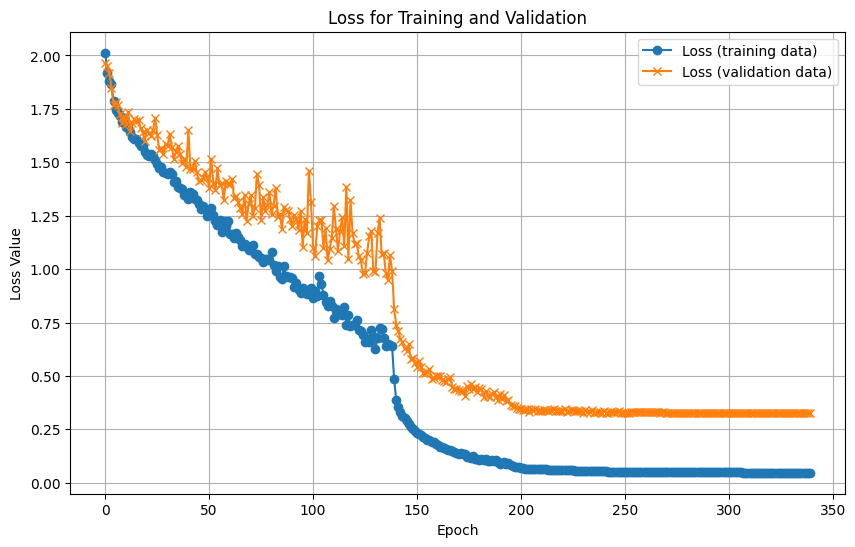

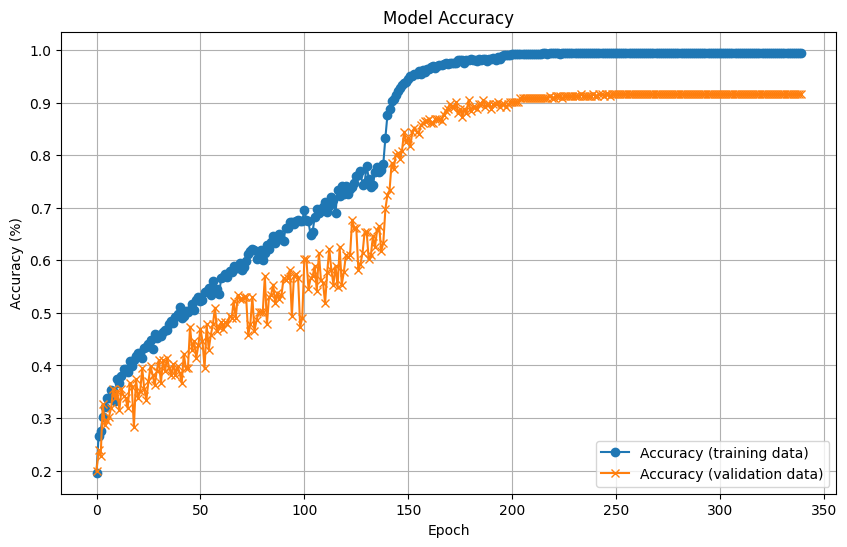

In [20]:
import matplotlib.pyplot as plt

# Check if 'history' object exists
if 'history' in locals() and hasattr(history, 'history'):
    # Plot history: Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss (training data)', marker='o')
    plt.plot(history.history['val_loss'], label='Loss (validation data)', marker='x')
    plt.title('Loss for Training and Validation')
    plt.ylabel('Loss Value')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

    # Plot history: Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['categorical_accuracy'], label='Accuracy (training data)', marker='o')
    plt.plot(history.history['val_categorical_accuracy'], label='Accuracy (validation data)', marker='x')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("The 'history' object is not defined or does not have the 'history' attribute.")


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predicted labels on the validation set
y_val_pred = np.argmax(model.predict(x_val), axis=1)

# Generate confusion matrix
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_val_pred)

# List of class names (update as per your dataset's labels)
index = ["Happy", "Sad", "Angry", "Fearful", "Neutral", "Disgust", "Surprise", "Other"]

# Ensure cm is square and matches the number of classes
assert cm.shape[0] == len(index), "Mismatch between confusion matrix size and class index."

# Calculate accuracy rates per class
values = cm.diagonal()  # True positive counts for each class
row_sum = np.sum(cm, axis=1)  # Total samples per class (row-wise sum)
acc = values / row_sum  # Per-class accuracy

# Display validation set predicted emotions accuracy
print("Validation set predicted emotions accuracy:")
for e in range(len(values)):
    print(f"{index[e]}: {acc[e]:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step
Validation set predicted emotions accuracy:
Happy: 0.8462
Sad: 0.9688
Angry: 0.8000
Fearful: 0.9444
Neutral: 0.9677
Disgust: 0.9310
Surprise: 0.9250
Other: 0.9333


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


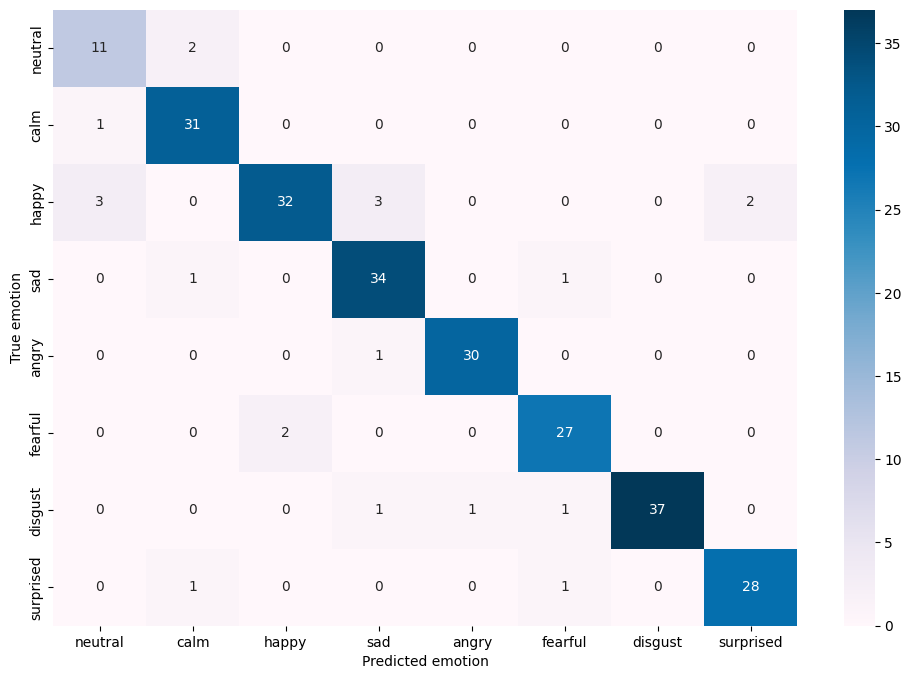

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded validation labels to integer class labels
y_val_class_int = np.argmax(y_val_class, axis=1)

# Generate predictions and convert them to integer class labels
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_val_class_int, y_pred_class)

# Define the class names (update to match your dataset's labels)
index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = index  # Columns are the same as index

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=index, columns=columns)

# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = plt.axes()
sns.heatmap(cm_df, ax=ax, cmap='PuBu', fmt="d", annot=True, cbar=True)

# Add axis labels
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

# Show the plot
plt.show()


In [24]:
from tensorflow.keras.models import model_from_json

# Serialize model to JSON
model_json = model.to_json()

# Paths to save model and weights (update these paths as needed)
saved_model_path = './model8723.json'  # Local path for JSON file
saved_weights_path = './model8723_.weights.h5'  # Local path for weights file

# Save the model architecture
with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

# Save the weights
model.save_weights(saved_weights_path)
print(f"Model architecture saved to {saved_model_path}")
print(f"Model weights saved to {saved_weights_path}")


Model architecture saved to ./model8723.json
Model weights saved to ./model8723_.weights.h5
